In [129]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D



# Preprocessing

In [57]:
hfcr = pd.read_csv('heart_failure_clinical_records_dataset.csv')
hfcr.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [58]:
hfcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


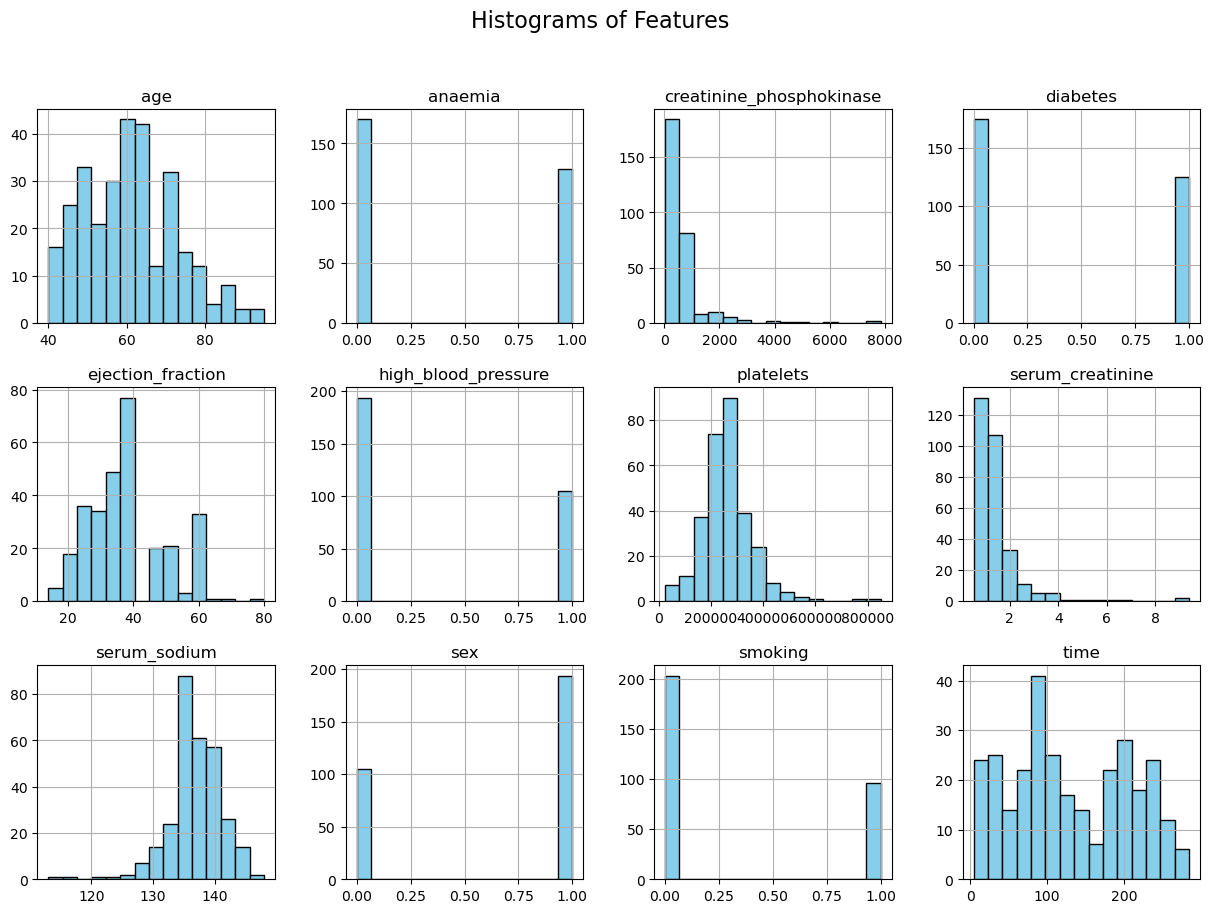

In [59]:
hfcr.iloc[:, :-1].hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()



In [60]:
binary_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
continuous_features_standardize = ["age", "ejection_fraction", "serum_sodium", "time"]
continuous_features_normalize = ["creatinine_phosphokinase", "platelets", "serum_creatinine"]

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

binary_data = hfcr[binary_features]

# Standardize normally distributed features
standardized_data = pd.DataFrame(
    standard_scaler.fit_transform(hfcr[continuous_features_standardize]),
    columns=continuous_features_standardize,
)

# Normalize skewed features
normalized_data = pd.DataFrame(
    minmax_scaler.fit_transform(hfcr[continuous_features_normalize]),
    columns=continuous_features_normalize,
)

target = hfcr['DEATH_EVENT']

# 4. Combine all features back into a single dataset
processed_data = pd.concat([binary_data, standardized_data, normalized_data, target], axis=1)

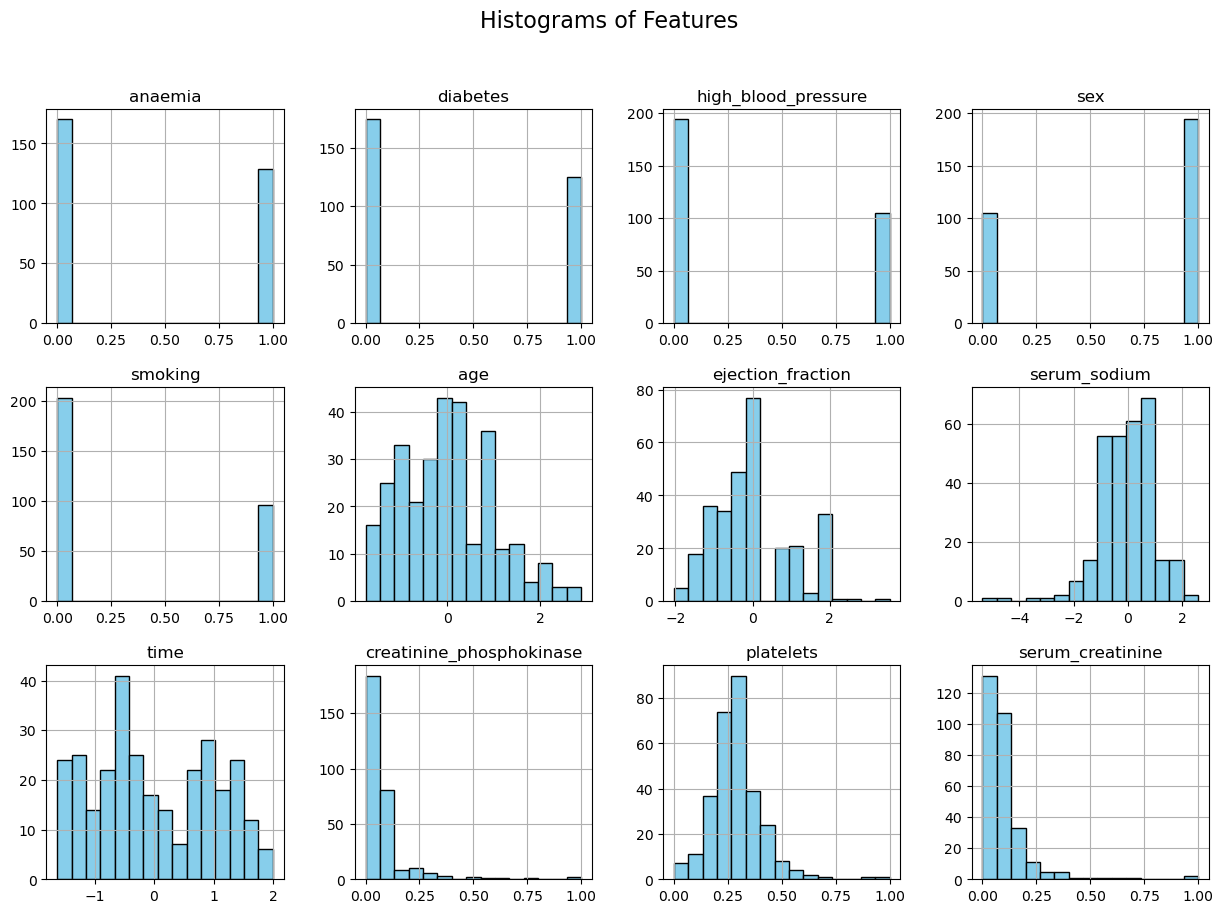

In [29]:
processed_data.iloc[:, :-1].hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()




#print(target.head())
#print(features.head())

In [61]:
features = processed_data.iloc[:,:-1]
target = processed_data.iloc[:,12]
#print(features.head())
#print(target.head())

In [62]:
# check for imbalances
target_counts = pd.Series(target).value_counts()
print(target_counts)

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64


In [63]:
features.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,ejection_fraction,serum_sodium,time,creatinine_phosphokinase,platelets,serum_creatinine
count,299.000000,299.000000,299.000000,299.000000,299.00000,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,299.000000,299.000000,299.000000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,5.703353e-16,-3.267546e-17,-8.673849e-16,-1.901118e-16,0.071299,0.288833,0.100436
std,0.496107,0.494067,0.478136,0.478136,0.46767,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,0.123793,0.118565,0.116237
min,0.000000,0.000000,0.000000,0.000000,0.00000,-1.754448e+00,-2.038387e+00,-5.363206e+00,-1.629502e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,-8.281242e-01,-6.841802e-01,-5.959961e-01,-7.389995e-01,0.011929,0.227179,0.044944
50%,0.000000,0.000000,0.000000,1.000000,0.00000,-7.022315e-02,-7.076750e-03,8.503384e-02,-1.969543e-01,0.028961,0.287186,0.067416
75%,1.000000,1.000000,1.000000,1.000000,1.00000,7.718891e-01,5.853888e-01,7.660638e-01,9.387595e-01,0.071319,0.337495,0.101124
max,1.000000,1.000000,1.000000,1.000000,1.00000,2.877170e+00,3.547716e+00,2.582144e+00,1.997038e+00,1.000000,1.000000,1.000000


In [78]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=4)

features_re, target_re = smote.fit_resample(features,target)

In [66]:
# check for imbalances
target_counts = pd.Series(target_re).value_counts()
print(target_counts)

DEATH_EVENT
1    203
0    203
Name: count, dtype: int64


In [67]:
features_re.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,ejection_fraction,serum_sodium,time,creatinine_phosphokinase,platelets,serum_creatinine
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,0.396552,0.381773,0.332512,0.623153,0.285714,0.084110,-0.111512,-0.047144,-0.205336,0.075691,0.284536,0.113752
std,0.489785,0.486421,0.471695,0.485194,0.452311,1.012207,1.006150,1.011068,1.000424,0.129870,0.110334,0.127031
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.754448,-2.038387,-5.363206,-1.629502,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.738433,-0.910013,-0.595996,-1.122948,0.012987,0.224148,0.056180
50%,0.000000,0.000000,0.000000,1.000000,0.000000,-0.070223,-0.260991,0.079341,-0.438469,0.032258,0.284591,0.078434
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.771889,0.162199,0.539054,0.729040,0.071319,0.335374,0.131884
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.877170,3.547716,2.582144,1.997038,1.000000,1.000000,1.000000


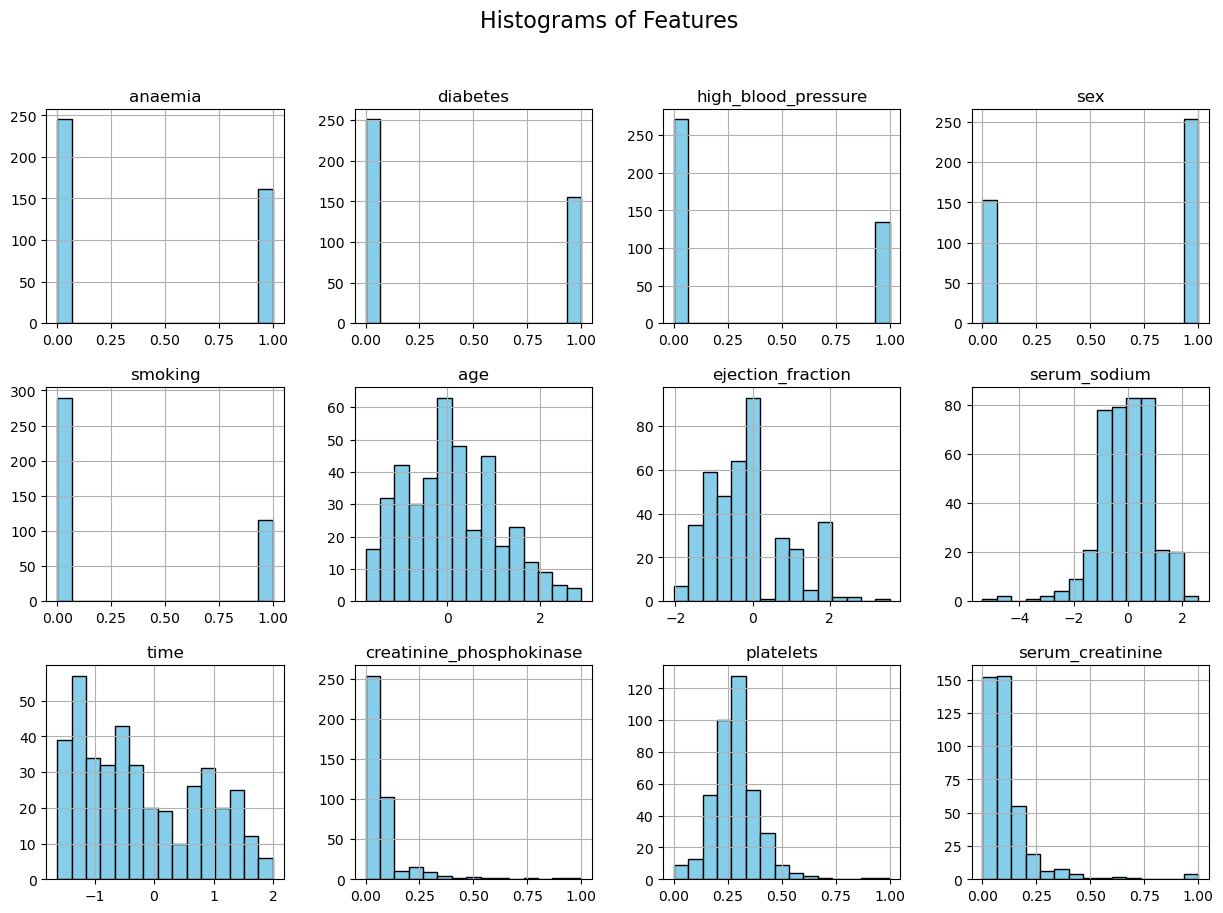

In [68]:
features_re.hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


<Axes: >

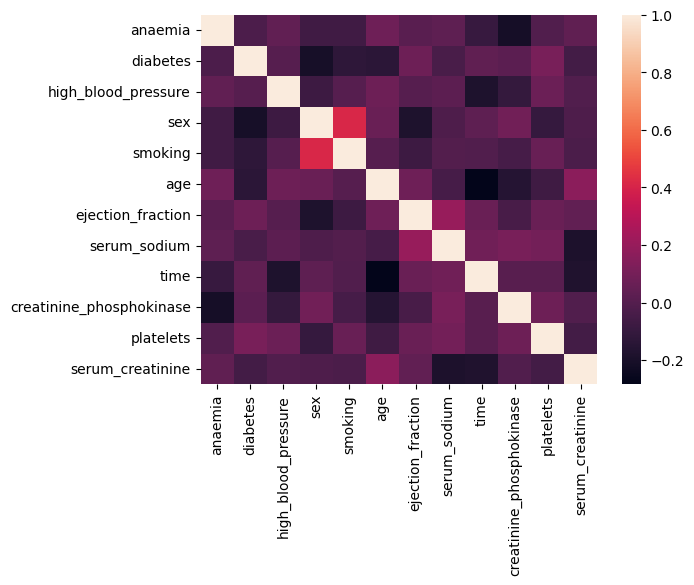

In [70]:
features_corr = features_re.corr()
sns.heatmap(features_corr)

In [74]:
#train/test
x1_train, x1_test, y1_train, y1_test = train_test_split(features_re, target_re, test_size=0.2, random_state=4)
x2_train, x2_test, y2_train, y2_test = train_test_split(features_re, target_re, test_size=0.5, random_state=4)
x3_train, x3_test, y3_train, y3_test = train_test_split(features_re, target_re, test_size=0.8, random_state=4)

In [75]:
# check out the splits

print(x1_test.shape)
print(x1_train.shape)

print(x2_test.shape)
print(x2_train.shape)

print(x3_test.shape)
print(x3_train.shape)


(82, 12)
(324, 12)
(203, 12)
(203, 12)
(325, 12)
(81, 12)


# Logistic Regression

In [136]:
splits = [0.2, 0.5, 0.8]

for i in range(3):
    x_train, x_test, y_train, y_test = train_test_split(features_re, target_re, test_size=splits[i], random_state=4)
    cross_val_score

KFold(n_splits=2, random_state=None, shuffle=False)
0
[203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256
 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292
 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310
 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328
 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346
 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29

In [90]:
clf1 = LogisticRegression(max_iter=1000)

clf1.fit(x1_train,y1_train)

pred1 = clf1.predict(x1_test)

accuracy1 = metrics.accuracy_score(y1_test, pred1)
print("Accuracy:", accuracy1)


Accuracy: 0.7439024390243902


In [92]:
clf2 = LogisticRegression(max_iter=1000)

clf2.fit(x2_train,y2_train)

pred2 = clf2.predict(x2_test)

accuracy2 = metrics.accuracy_score(y2_test, pred2)
print("Accuracy:", accuracy2)

Accuracy: 0.7684729064039408


In [93]:
clf3 = LogisticRegression(max_iter=1000)

clf3.fit(x3_train,y3_train)

pred3 = clf3.predict(x3_test)

accuracy3 = metrics.accuracy_score(y3_test, pred3)
print("Accuracy:", accuracy3)

Accuracy: 0.8


In [94]:
tot_acc_lr = (accuracy1 + accuracy2 + accuracy3)/3
print(tot_acc_lr)

0.7707917818094437


In [96]:
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, features_re,target_re, cv=5)
print(scores.mean(), scores.std())

0.7737127371273712 0.11499421779765706


# KNN

In [100]:
knn1 = KNeighborsClassifier()

knn1.fit(x1_train,y1_train)

pred1 = knn1.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.8414634146341463


In [101]:
knn2 = KNeighborsClassifier()

knn2.fit(x2_train,y2_train)

pred2 = knn2.predict(x2_test)

accuracy2 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.7980295566502463


In [102]:
knn3 = KNeighborsClassifier()

knn3.fit(x3_train,y3_train)

pred3 = knn3.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred3)
print("Accuracy 3:", accuracy3)

Accuracy 3: 0.7630769230769231


In [103]:
tot_acc_knn = (accuracy1 + accuracy2 + accuracy3)/3
print(tot_acc_knn)

0.800856631453772


In [105]:
clf = KNeighborsClassifier()
scores = cross_val_score(clf, features_re, target_re, cv=5)
print(scores.mean(), scores.std())

0.8056910569105693 0.06654414997438078


In [106]:
auc_roc = roc_auc_score(pred1, y1_test)
print(auc_roc)

0.8580547112462006


# Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier

In [115]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)

clf = clf.fit(x1_train, y1_train)

pred1 = clf.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.7195121951219512


In [116]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)

clf = clf.fit(x2_train, y2_train)

pred2 = clf.predict(x2_test)

accuracy2 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.7783251231527094


In [117]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)

clf = clf.fit(x3_train, y3_train)

pred1 = clf.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred3)
print("Accuracy 3:", accuracy3)

Accuracy 3: 0.7630769230769231


In [118]:
tot_acc_knn = (accuracy1 + accuracy2 + accuracy3)/3
print(tot_acc_knn)

0.7536380804505279


In [119]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
scores = cross_val_score(clf, features_re, target_re, cv=5)
print(scores.mean(), scores.std())

0.7936464920204759 0.115998039760485


# SVM

In [120]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=100, gamma=0.1, )
clf.fit(x1_train,y1_train)

pred1 = clf.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.8536585365853658


In [124]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=100, gamma=0.1, )
clf.fit(x2_train,y2_train)

pred2 = clf.predict(x2_test)

accuracy2 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.8177339901477833


In [125]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=100, gamma=0.1, )
clf.fit(x3_train,y3_train)

pred3 = clf.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred1)
print("Accuracy 3:", accuracy3)

ValueError: Found input variables with inconsistent numbers of samples: [325, 82]

# DATASET #2

In [52]:
pd_hrt = pd.read_csv('heart.dat', delim_whitespace=True, header=None)
print(pd_hrt)

       0    1    2      3      4    5    6      7    8    9    10   11   12  \
0    70.0  1.0  4.0  130.0  322.0  0.0  2.0  109.0  0.0  2.4  2.0  3.0  3.0   
1    67.0  0.0  3.0  115.0  564.0  0.0  2.0  160.0  0.0  1.6  2.0  0.0  7.0   
2    57.0  1.0  2.0  124.0  261.0  0.0  0.0  141.0  0.0  0.3  1.0  0.0  7.0   
3    64.0  1.0  4.0  128.0  263.0  0.0  0.0  105.0  1.0  0.2  2.0  1.0  7.0   
4    74.0  0.0  2.0  120.0  269.0  0.0  2.0  121.0  1.0  0.2  1.0  1.0  3.0   
..    ...  ...  ...    ...    ...  ...  ...    ...  ...  ...  ...  ...  ...   
265  52.0  1.0  3.0  172.0  199.0  1.0  0.0  162.0  0.0  0.5  1.0  0.0  7.0   
266  44.0  1.0  2.0  120.0  263.0  0.0  0.0  173.0  0.0  0.0  1.0  0.0  7.0   
267  56.0  0.0  2.0  140.0  294.0  0.0  2.0  153.0  0.0  1.3  2.0  0.0  3.0   
268  57.0  1.0  4.0  140.0  192.0  0.0  0.0  148.0  0.0  0.4  2.0  0.0  6.0   
269  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   

     13  
0     2  
1     1  
2     2  
3     1  
4

C:\Users\jacob\AppData\Local\Temp\ipykernel_24024\2621637248.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pd_hrt = pd.read_csv('heart.dat', delim_whitespace=True, header=None)


In [258]:
pd_hrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       270 non-null    float64
 1   1       270 non-null    float64
 2   2       270 non-null    float64
 3   3       270 non-null    float64
 4   4       270 non-null    float64
 5   5       270 non-null    float64
 6   6       270 non-null    float64
 7   7       270 non-null    float64
 8   8       270 non-null    float64
 9   9       270 non-null    float64
 10  10      270 non-null    float64
 11  11      270 non-null    float64
 12  12      270 non-null    float64
 13  13      270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.7 KB


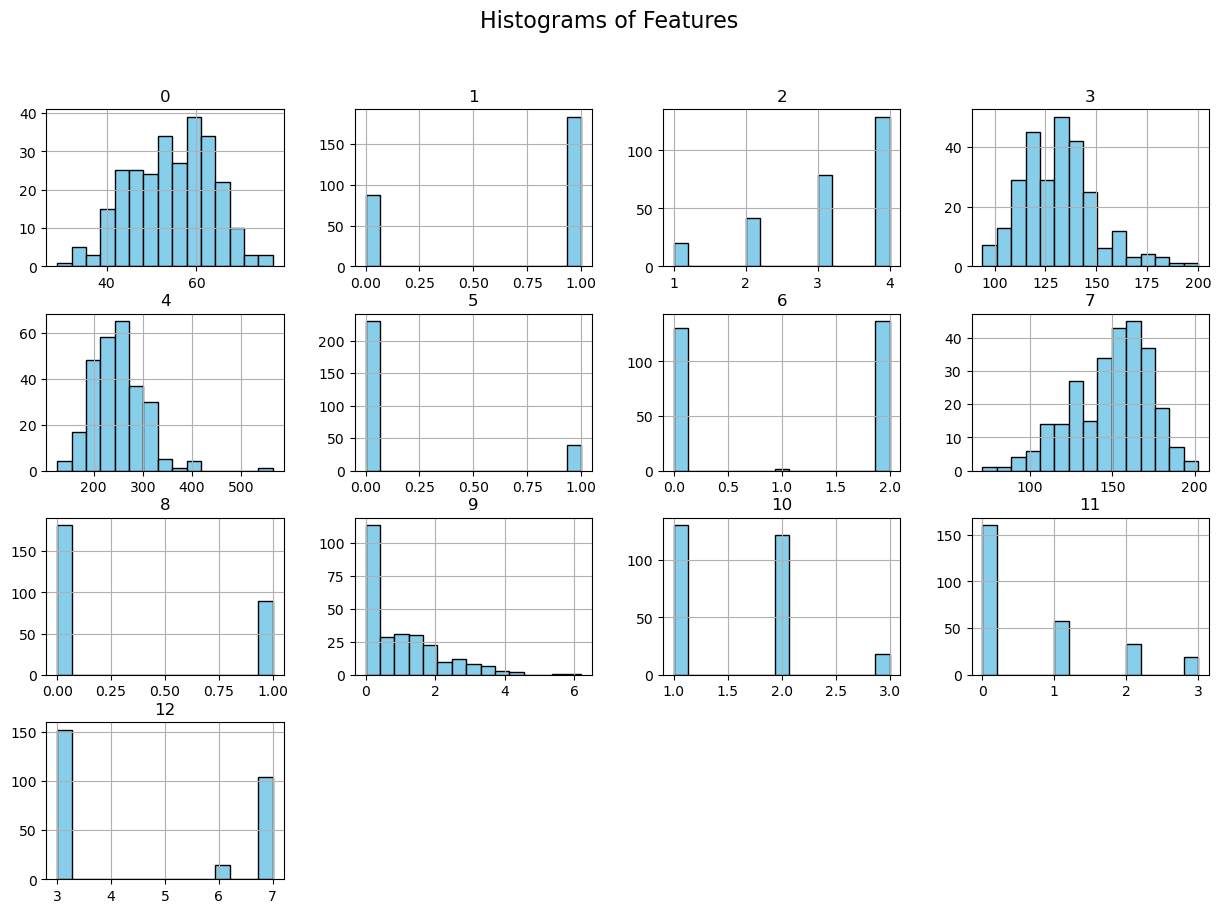

In [259]:
pd_hrt.iloc[:, :-1].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


In [260]:
binary_features = [1, 5, 8]
continuous_features_standardize = [0, 3, 4, 6, 7, 10, 12]
continuous_features_normalize = [2, 9, 11]

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

binary_data = pd_hrt[binary_features]

# Standardize normally distributed features
standardized_data = pd.DataFrame(
    standard_scaler.fit_transform(pd_hrt[continuous_features_standardize]),
    columns=continuous_features_standardize,
)

# Normalize skewed features
normalized_data = pd.DataFrame(
    minmax_scaler.fit_transform(pd_hrt[continuous_features_normalize]),
    columns=continuous_features_normalize,
)

target = pd_hrt.iloc[:, -1]

# 4. Combine all features back into a single dataset
processed_data = pd.concat([binary_data, standardized_data, normalized_data, target], axis=1)

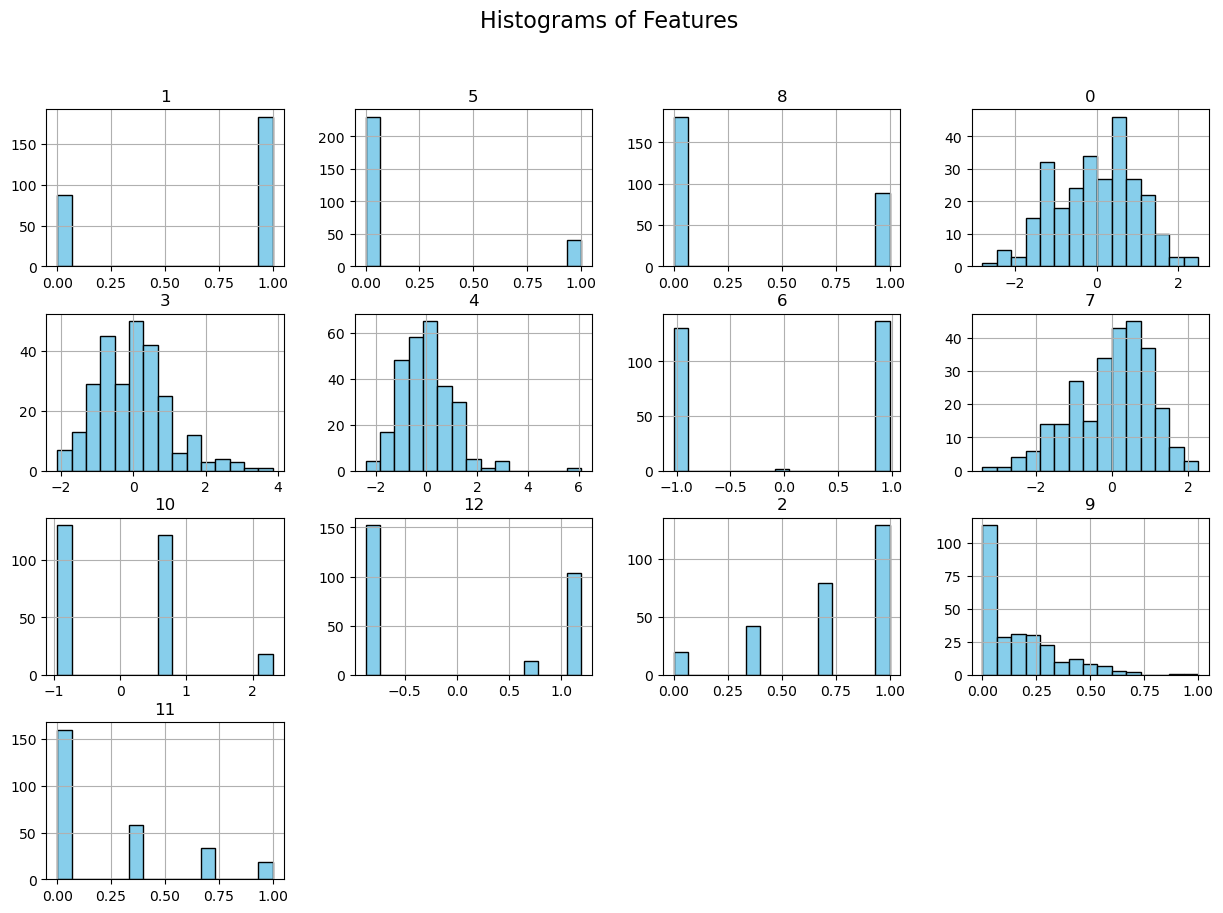

In [261]:
processed_data.iloc[:, :-1].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


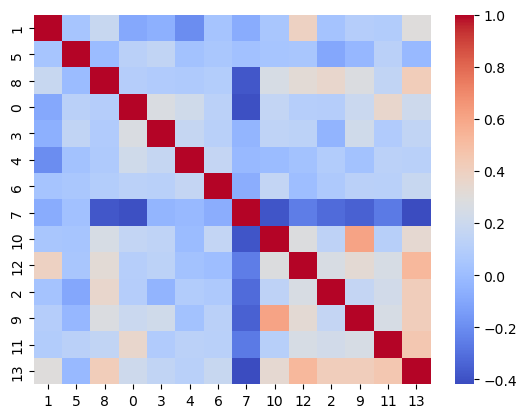

In [272]:
corr_matrix = processed_data.corr()

sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

In [262]:
target_counts = pd.Series(target).value_counts()
print(target_counts)

13
1    150
2    120
Name: count, dtype: int64


In [263]:
features = processed_data.iloc[:, :-1]
target = processed_data.iloc[:, -1]

In [264]:
x1_train, x1_test, y1_train, y1_test = train_test_split(features, target, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(features, target, test_size=0.5, random_state=42)
x3_train, x3_test, y3_train, y3_test = train_test_split(features, target, test_size=0.8, random_state=42)

# Naive Bayes

In [265]:
gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb3 = GaussianNB()

gnb1.fit(x1_train, y1_train)
gnb2.fit(x2_train, y2_train)
gnb3.fit(x3_train, y3_train)

GaussianNB()

In [266]:
pred1 = gnb1.predict(x1_test)
pred2 = gnb2.predict(x2_test)
pred3 = gnb3.predict(x3_test)

In [267]:
print("Gaussian Naive Bayes 1st model accuracy(in %):", 
      metrics.accuracy_score(y1_test, pred1)*100)

print("Gaussian Naive Bayes 2nd model accuracy(in %):", 
      metrics.accuracy_score(y2_test, pred2)*100)

print("Gaussian Naive Bayes 3rd model accuracy(in %):", 
      metrics.accuracy_score(y3_test, pred3)*100)

Gaussian Naive Bayes 1st model accuracy(in %): 90.74074074074075
Gaussian Naive Bayes 2nd model accuracy(in %): 83.7037037037037
Gaussian Naive Bayes 3rd model accuracy(in %): 81.48148148148148


In [53]:
auc_roc = roc_auc_score(pred1, y1_test)
print(auc_roc)

0.9166666666666666


# Logistic Regression

In [54]:
clf1 = LogisticRegression(max_iter=1000)

clf1.fit(x1_train,y1_train)

pred1 = clf1.predict(x1_test)

accuracy1 = metrics.accuracy_score(y1_test, pred1)
print("Accuracy:", accuracy1)


Accuracy: 0.9074074074074074


In [273]:
clf2 = LogisticRegression(max_iter=1000)

clf2.fit(x2_train,y2_train)

pred2 = clf2.predict(x2_test)

accuracy2 = metrics.accuracy_score(y2_test, pred2)
print("Accuracy:", accuracy2)

Accuracy: 0.7877358490566038


In [56]:
clf3 = LogisticRegression(max_iter=1000)

clf3.fit(x3_train,y3_train)

pred3 = clf3.predict(x3_test)

accuracy3 = metrics.accuracy_score(y3_test, pred3)
print("Accuracy:", accuracy3)

Accuracy: 0.7731481481481481


# KNN

In [57]:
knn1 = KNeighborsClassifier()

knn1.fit(x1_train,y1_train)

pred1 = knn1.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.8148148148148148


In [58]:
knn2 = KNeighborsClassifier()

knn2.fit(x2_train,y2_train)

pred2 = knn2.predict(x2_test)

accuracy2 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.762962962962963


In [59]:
knn3 = KNeighborsClassifier()

knn3.fit(x3_train,y3_train)  

pred3 = knn3.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred3)
print("Accuracy 3:", accuracy3)

Accuracy 3: 0.7361111111111112


# SVM

In [280]:
clf = SVC(kernel='rbf', C=100, gamma=0.1, )
clf.fit(x1_train,y1_train)

pred1 = clf.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.9058823529411765


In [279]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}  

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(x1_train, y1_train)
print(grid.best_params_) 
  

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.522 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.912 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.824 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.853 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.838 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.721 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

# Dataset 3

In [4]:
spectf = pd.read_csv('SPECTF.train', header= None)

print(spectf.head())
print(spectf.shape)

   0   1   2   3   4   5   6   7   8   9   ...  35  36  37  38  39  40  41  \
0   1  59  52  70  67  73  66  72  61  58  ...  66  56  62  56  72  62  74   
1   1  72  62  69  67  78  82  74  65  69  ...  65  71  63  60  69  73  67   
2   1  71  62  70  64  67  64  79  65  70  ...  73  70  66  65  64  55  61   
3   1  69  71  70  78  61  63  67  65  59  ...  61  61  66  65  72  73  68   
4   1  70  66  61  66  61  58  69  69  72  ...  67  69  70  66  70  64  60   

   42  43  44  
0  74  64  67  
1  71  56  58  
2  41  51  46  
3  68  59  63  
4  55  49  41  

[5 rows x 45 columns]
(80, 45)


In [ ]:
spectf_test = pd.read_csv('SPECTF.test', header= None)

#print(spectf_test.head())
#print(spectf_test.shape)

   0   1   2   3   4   5   6   7   8   9   ...  35  36  37  38  39  40  41  \
0   1  67  68  73  78  65  63  67  60  63  ...  61  56  76  75  74  77  76   
1   1  75  74  71  71  62  58  70  64  71  ...  66  62  68  69  69  66  64   
2   1  83  64  66  67  67  74  74  72  64  ...  67  64  69  63  68  54  65   
3   1  72  66  65  65  64  61  71  78  73  ...  69  68  68  63  71  72  65   
4   1  62  60  69  61  63  63  70  68  70  ...  66  66  58  56  72  73  71   

   42  43  44  
0  74  59  68  
1  58  57  52  
2  64  43  42  
3  63  58  60  
4  64  49  42  

[5 rows x 45 columns]
(187, 45)


In [6]:
spectf_df = pd.concat([spectf, spectf_test], axis = 0)
print(spectf_df.shape)

(267, 45)


In [ ]:
#spectf_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 0 to 186
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       267 non-null    int64
 1   1       267 non-null    int64
 2   2       267 non-null    int64
 3   3       267 non-null    int64
 4   4       267 non-null    int64
 5   5       267 non-null    int64
 6   6       267 non-null    int64
 7   7       267 non-null    int64
 8   8       267 non-null    int64
 9   9       267 non-null    int64
 10  10      267 non-null    int64
 11  11      267 non-null    int64
 12  12      267 non-null    int64
 13  13      267 non-null    int64
 14  14      267 non-null    int64
 15  15      267 non-null    int64
 16  16      267 non-null    int64
 17  17      267 non-null    int64
 18  18      267 non-null    int64
 19  19      267 non-null    int64
 20  20      267 non-null    int64
 21  21      267 non-null    int64
 22  22      267 non-null    int64
 23  23      267 non-null

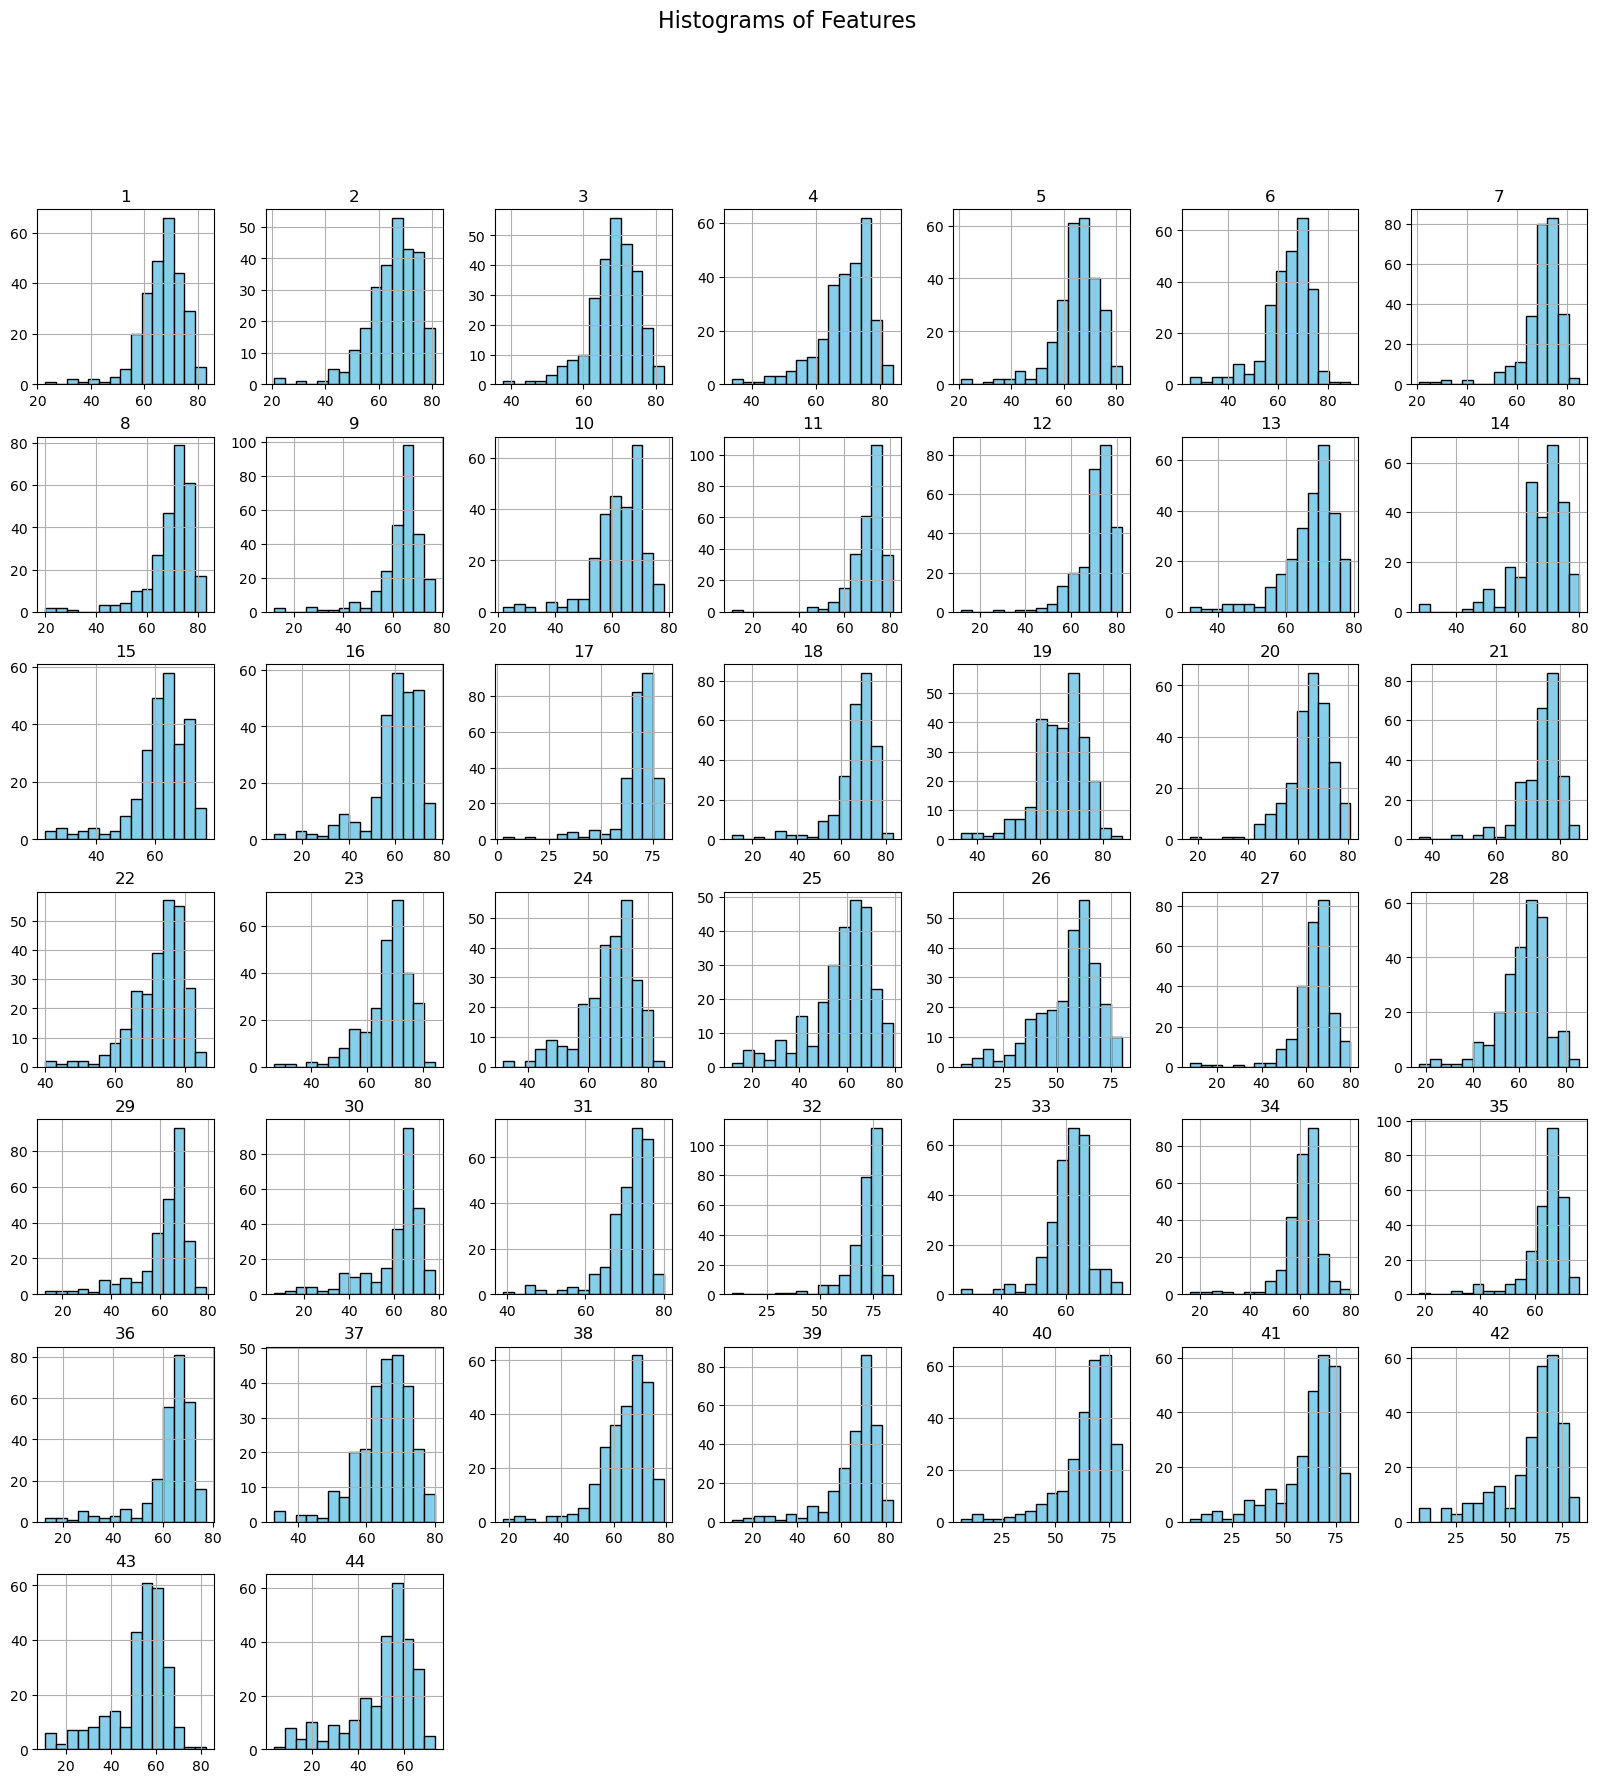

In [8]:
spectf_df.iloc[:, 1:].hist(bins=15, figsize=(20, 20), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()

In [9]:


scaler = StandardScaler()
data_array = spectf_df.to_numpy()
scaled_data = scaler.fit_transform(data_array[:, 1:])
first_col = data_array[:, 0]


spectf_df_std = np.concatenate((first_col[:, np.newaxis],scaled_data,), axis=1)

spectf_df_std = pd.DataFrame(spectf_df_std)
print(spectf_df_std.head())



    0         1         2         3         4         5         6         7   \
0  1.0 -0.872332 -1.369846  0.200891 -0.248093  0.930613  0.214933  0.219599   
1  1.0  0.706325 -0.309089  0.048942 -0.248093  1.498164  1.905895  0.459407   
2  1.0  0.584890 -0.309089  0.200891 -0.606151  0.249552  0.003562  1.058926   
3  1.0  0.342019  0.645592  0.200891  1.064787 -0.431509 -0.102123 -0.379920   
4  1.0  0.463455  0.115213 -1.166645 -0.367445 -0.431509 -0.630549 -0.140112   

         8         9   ...        35        36        37        38        39  \
0 -0.885042 -0.588178  ...  0.264263 -0.602538 -0.412572 -0.887855  0.505418   
1 -0.463067  0.633518  ...  0.138041  0.770139 -0.285517 -0.454676  0.256745   
2 -0.463067  0.744582  ...  1.147819  0.678627  0.095648  0.086798 -0.157710   
3 -0.463067 -0.477115  ... -0.366848 -0.144979  0.095648  0.086798  0.505418   
4 -0.041091  0.966708  ...  0.390485  0.587115  0.603868  0.195093  0.339636   

         40        41        42       

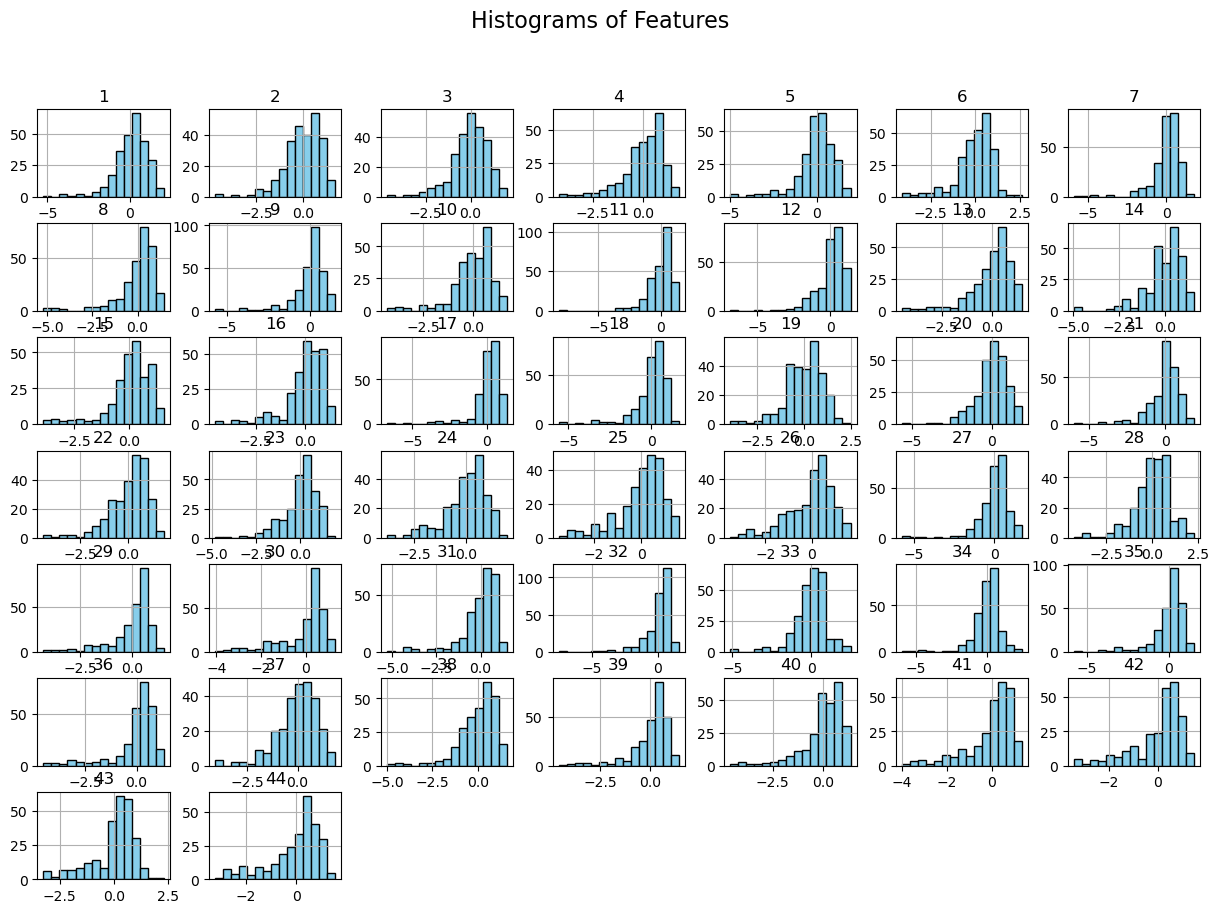

In [10]:
spectf_df_std.iloc[:, 1:].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


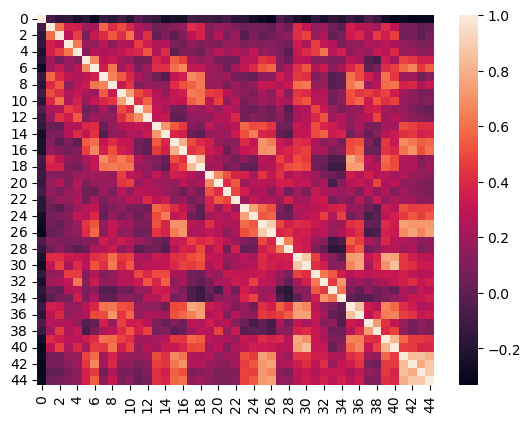

In [11]:
corr_matrix = spectf_df_std.corr()

sns.heatmap(corr_matrix)
plt.show()

In [12]:
features = spectf_df_std.iloc[:, 1:]
target = spectf_df_std.iloc[:, 0]

In [13]:
x1_train, x1_test, y1_train, y1_test = train_test_split(features, target, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(features, target, test_size=0.5, random_state=42)
x3_train, x3_test, y3_train, y3_test = train_test_split(features, target, test_size=0.8, random_state=42)

# Naive Bayes

In [14]:
gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb3 = GaussianNB()

gnb1.fit(x1_train, y1_train)
gnb2.fit(x2_train, y2_train)
gnb3.fit(x3_train, y3_train)

NameError: name 'GaussianNB' is not defined

In [195]:
pred1 = gnb1.predict(x1_test)
pred2 = gnb2.predict(x2_test)
pred3 = gnb3.predict(x3_test)

In [196]:
print("Gaussian Naive Bayes 1st model accuracy(in %):", 
      metrics.accuracy_score(y1_test, pred1)*100)

print("Gaussian Naive Bayes 2nd model accuracy(in %):", 
      metrics.accuracy_score(y2_test, pred2)*100)

print("Gaussian Naive Bayes 3rd model accuracy(in %):", 
      metrics.accuracy_score(y3_test, pred3)*100)

Gaussian Naive Bayes 1st model accuracy(in %): 70.37037037037037
Gaussian Naive Bayes 2nd model accuracy(in %): 70.8955223880597
Gaussian Naive Bayes 3rd model accuracy(in %): 75.23364485981308


# Logistic Regression

In [197]:
clf1 = LogisticRegression(max_iter=1000)

clf1.fit(x1_train,y1_train)

pred1 = clf1.predict(x1_test)

accuracy1 = metrics.accuracy_score(y1_test, pred1)
print("Accuracy:", accuracy1)


Accuracy: 0.8333333333333334


In [198]:
clf2 = LogisticRegression(max_iter=1000)

clf2.fit(x2_train,y2_train)

pred2 = clf2.predict(x2_test)

accuracy2 = metrics.accuracy_score(y2_test, pred2)
print("Accuracy:", accuracy2)

Accuracy: 0.7910447761194029


In [199]:
clf3 = LogisticRegression(max_iter=1000)

clf3.fit(x3_train,y3_train)

pred3 = clf3.predict(x3_test)

accuracy3 = metrics.accuracy_score(y3_test, pred3)
print("Accuracy:", accuracy3)

Accuracy: 0.7616822429906542


# KNN

In [200]:
knn1 = KNeighborsClassifier()

knn1.fit(x1_train,y1_train)

pred1 = knn1.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.7222222222222222


In [201]:
knn2 = KNeighborsClassifier()

knn2.fit(x2_train,y2_train)

pred2 = knn2.predict(x2_test)

accuracy2 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.7611940298507462


In [202]:
knn3 = KNeighborsClassifier()

knn3.fit(x3_train,y3_train)  

pred3 = knn3.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred3)
print("Accuracy 3:", accuracy3)

Accuracy 3: 0.6822429906542056


# SVM 

In [206]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf')
clf.fit(x1_train,y1_train)

pred1 = clf.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.8148148148148148


In [208]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf')
clf.fit(x2_train,y2_train)

pred2 = clf.predict(x2_test)

accuracy1 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.7611940298507462


In [209]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(x3_train,y3_train)

pred3 = clf.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred3)
print("Accuracy 3:", accuracy3)

Accuracy 3: 0.719626168224299


# Decision Tree

In [211]:
from sklearn.tree import DecisionTreeClassifier

In [215]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)

clf = clf.fit(x1_train, y1_train)

pred1 = clf.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.8333333333333334


In [216]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)

clf = clf.fit(x2_train, y2_train)

pred2 = clf.predict(x2_test)

accuracy2 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.8134328358208955


In [217]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)

clf = clf.fit(x3_train, y3_train)

pred3 = clf.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred3)
print("Accuracy 3:", accuracy3)

Accuracy 3: 0.7476635514018691


In [21]:
input_dim = len(x1_train.columns)

neurons = 64
epochs = 100
model = Sequential()

model.add(Dense(neurons, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

history = model.fit(x1_train, y1_train, epochs=epochs, verbose=0, validation_split=0.33)
predictions = model.predict(x1_test)



Epoch 1/100
5/5 [==============================] - 5s 278ms/step - loss: 0.5659 - accuracy: 0.6479 - val_loss: 0.5410 - val_accuracy: 0.6620
Epoch 2/100
5/5 [==============================] - 0s 58ms/step - loss: 0.5135 - accuracy: 0.7113 - val_loss: 0.5201 - val_accuracy: 0.7042
Epoch 3/100
5/5 [==============================] - 0s 32ms/step - loss: 0.4763 - accuracy: 0.7887 - val_loss: 0.5029 - val_accuracy: 0.7042
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 0.4452 - accuracy: 0.8310 - val_loss: 0.4913 - val_accuracy: 0.7183
Epoch 5/100
5/5 [==============================] - 0s 26ms/step - loss: 0.4203 - accuracy: 0.8380 - val_loss: 0.4827 - val_accuracy: 0.7465
Epoch 6/100
5/5 [==============================] - 0s 26ms/step - loss: 0.3988 - accuracy: 0.8521 - val_loss: 0.4768 - val_accuracy: 0.7465
Epoch 7/100
5/5 [==============================] - 0s 29ms/step - loss: 0.3799 - accuracy: 0.8662 - val_loss: 0.4713 - val_accuracy: 0.7606
Epoch 8/100
5/5 [==

In [22]:
predictions = (predictions > 0.5) * 1
scores = model.evaluate(x1_test,y1_test, verbose=0)


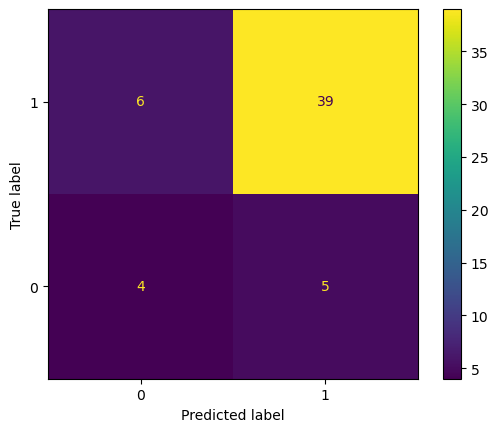

In [23]:
cfm = confusion_matrix(y1_test, predictions)
disp = ConfusionMatrixDisplay(cfm)
disp.plot()
plt.gca().invert_yaxis()
plt.show()